In [1]:
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
from spacy import displacy

from config import Config

In [4]:
nlp = spacy.load('Jodie')

c:\machine_learning\10k-emerging-risk-detection\venv\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_Jodie' (0.0.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
file_name = '0001104659-06-084288.txt'
data_file = os.path.join(Config.risk_dir(), file_name)

In [3]:
with open(data_file, 'r') as df:
    data = df.read()

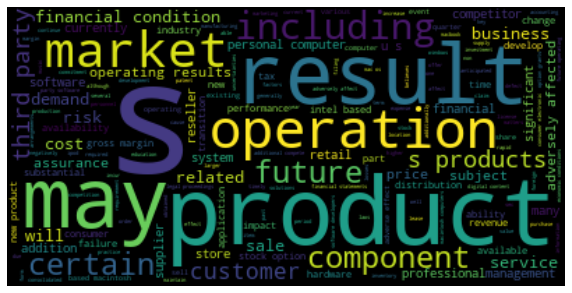

In [7]:
wordcloud = WordCloud(stopwords=STOPWORDS).generate(data.lower())
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
doc = nlp(data)

In [38]:
# Render the dependency parse immediately inside Jupyter:
displacy.render(doc[:53], style='ent', jupyter=True, options={'distance': 110})

In [7]:
sents = list(doc.sents)

ValueError: [E030] Sentence boundaries unset. You can add the 'sentencizer' component to the pipeline with: nlp.add_pipe(nlp.create_pipe('sentencizer')) Alternatively, add the dependency parser, or set sentence boundaries by setting doc[i].is_sent_start.

In [35]:
doc[:53]

Because of the following factors, as well as other factors affecting the Company’s operating results and financial condition, past financial performance should not be considered to be a reliable indicator of future performance, and investors should not use historical trends to anticipate results or trends in future periods.

In [43]:
doc.ents

(the Special Committee of the Board of Directors,
 June 29, 2006,
 between 1997 and 2001,
 CEO”,
 Steve Jobs,
 Special Committee of,
 Audit and Finance Committee,
 SEC,
 SEC,
 SEC,
 the United States,
 Attorney’s Office,
 the Northern District,
 California,
 August 2006,
 NASDAQ Staff Determination,
 the quarter ended July 1, 2006,
 the “Third Quarter Form 10-Q”,
 the NASDAQ Stock Market,
 October 24, 2006,
 the NASDAQ Listing Qualifications Panel,
 Third Quarter Form 10-Q,
 SEC,
 December 29, 2006,
 December 29, 2006,
 the Third Quarter Form 10-Q,
 SEC,
 Marketplace Rule 4310(c)(14,
 NASDAQ,
 SEC,
 SEC,
 the NASDAQ Global Select Market,
 Part I, Item 3,
 U.S.,
 U.S.,
 Linux,
 the Mac OS,
 The Mac OS,
 Windows,
 Linux,
 Macintosh,
 the Mac OS,
 MP3,
 U.S.,
 U.S.,
 one,
 1:1,
 1:1,
 ASICs,
 DRAM,
 NAND,
 TFT,
 one,
 Intel,
 Macintosh,
 June 2005,
 Intel,
 2006,
 Intel,
 MacBook,
 Mac Pro,
 Mac,
 Intel,
 Macintosh,
 August 2006,
 Xserve,
 November 2006,
 Intel,
 Intel,
 Macintosh,
 Intel

In [6]:
STOPWORDS.add('company')

In [10]:
with open('..\\neg_sentences.txt', 'r') as f:
    neg_sentences = f.read().replace('\n', ' ')

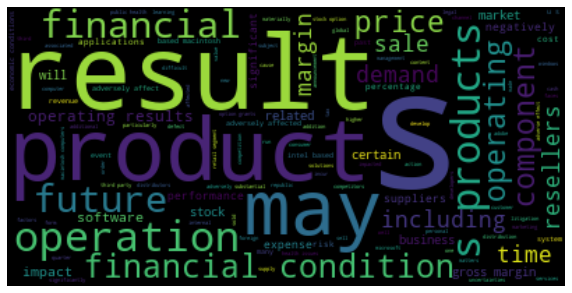

In [12]:
wordcloud = WordCloud(stopwords=STOPWORDS).generate(neg_sentences.lower())
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()